In [1]:
import numpy as np
import gym
import hiive.mdptoolbox.mdp as mdp
import itertools
from collections import defaultdict
import sys
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
def get_score(env, policy, episodes=10000, print_out=True):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                # print('You have got the fucking Frisbee after {} steps'.format(steps))
                steps_list.append(steps)
                break
            elif done and reward == 0:
                # print("You fell in a hole!")
                misses += 1
                break
                
    mean_step = np.mean(steps_list)
    miss_pct = misses/episodes
    if (print_out):
        print('----------------------------------------------')
        print('You took an average of {:.0f} steps to get the Goal'.format(mean_step))
        print('And you fell in the hole {:.2f} % of the times'.format(miss_pct * 100))
        print('----------------------------------------------')
    
    return (mean_step, miss_pct)

In [3]:
def convert_gym_transition_matrix(env):
    """
    env: gym env
    P: transiftion matrix for mdptoolbox use
    R: reward matrix for mdptoolbox use
    """
    nA, nS = env.nA, env.nS
    P = np.zeros([nA, nS, nS])
    R = np.zeros([nS, nA])
    env.reset()
    
    for s in range(nS):
        for a in range(nA):
            transitions = env.P[s][a]
            for prob, next_s, reward, done in transitions:
                P[a,s,next_s] += prob
                R[s, a] = reward
            P[a,s,:] /= np.sum(P[a,s,:])
    return (P, R)

In [4]:
def policy_string(policy, action_str=['<','v','>','^']):
    """
    default: [0=left, 1=down, 2=right, 3=up]
    """
    policy_str = [action_str[p] for p in policy]
    policy_str = np.asarray(policy_str)
    
    return policy_str

# Deterministic

In [166]:
## set random seed
np.random.seed(0)

rand_map = generate_random_map(size=4, p=0.6)
env = gym.make("FrozenLake-v0", desc=rand_map_4, is_slippery=False)

env.reset()
P, R = convert_gym_transition_matrix(env)

vi = mdp.ValueIteration(P, R, gamma=0.8)
vi.run()

vi_policy = np.asarray(vi.policy)
vi_policy_str = policy_string(vi_policy, action_str=action_str)
run_stats = vi.run_stats

iters = []
rewards = []
mean_V = []
max_V = []
time = []
error = []
for s in run_stats:
    iters.append(s['Iteration'])
    rewards.append(s['Reward'])
    mean_V.append(s['Mean V'])
    max_V.append(s['Max V'])
    time.append(s['Time'])
    error.append(s['Error'])

env.render()
print(vi_policy.reshape((nrow, ncol)))
print(vi_policy_str.reshape((nrow, ncol)))
get_score(env, vi_policy, episodes=100000)


SFFF
HFFF
HFFF
FFHG
[[2 1 1 1]
 [0 1 1 1]
 [0 2 2 1]
 [2 3 0 0]]
[['>' 'v' 'v' 'v']
 ['<' 'v' 'v' 'v']
 ['<' '>' '>' 'v']
 ['>' '^' '<' '<']]
----------------------------------------------
You took an average of 6 steps to get the Goal
And you fell in the hole 0.00 % of the times
----------------------------------------------


(6.0, 0.0)

# Stochastic

In [5]:
from gym.envs.toy_text.frozen_lake import generate_random_map
## set random seed
np.random.seed(0)

rand_map_4 = generate_random_map(size=4, p=0.6)
env_4 = gym.make("FrozenLake-v0", desc=rand_map_4, is_slippery=True)

rand_map_16 = generate_random_map(size=16, p=0.9)
env_16= gym.make("FrozenLake-v0", desc=rand_map_16, is_slippery=True)

# env_4.render()
# env_20.render()

In [6]:
action_str=['<','v','>','^'] #[0=left, 1=down, 2=right, 3=up]

## Frozen Lake 4x4

In [7]:
env = env_4
nrow = env.env.nrow
ncol = env.env.ncol
env.render()


SFFF
HFFF
HFFF
FFHG


### Value Iteration

In [170]:
gamma = np.round(np.arange(0.1, 1.0, 0.1), 2)
print(gamma)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [171]:
vi_policies = []
for g in gamma:
    env.reset()
    P, R = convert_gym_transition_matrix(env)
    
    vi = mdp.ValueIteration(P, R, gamma=g)
    vi.run()
    vi_policies.append(vi.policy)

print(np.asarray(vi_policies))

[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0]
 [0 0 1 2 0 1 1 1 0 1 3 0 0 0 0 0]
 [1 2 2 2 0 2 2 1 0 2 3 0 1 0 0 0]
 [3 2 2 2 0 2 2 1 0 2 3 0 1 0 0 0]
 [3 2 2 2 0 2 2 1 0 2 3 0 1 0 0 0]
 [3 2 2 2 0 2 2 1 0 2 3 0 1 0 0 0]
 [3 2 2 2 0 2 2 2 0 2 3 0 1 0 0 0]]


In [183]:
env.reset()
P, R = convert_gym_transition_matrix(env)

vi = mdp.ValueIteration(P, R, gamma=0.8)
vi.run()

vi_policy = np.asarray(vi.policy)
vi_policy_str = policy_string(vi_policy, action_str=action_str)
run_stats = vi.run_stats

iters = []
rewards = []
mean_V = []
max_V = []
time = []
error = []
for s in run_stats:
    iters.append(s['Iteration'])
    rewards.append(s['Reward'])
    mean_V.append(s['Mean V'])
    max_V.append(s['Max V'])
    time.append(s['Time'])
    error.append(s['Error'])

print(vi_policy.reshape((nrow, ncol)))
print(vi_policy_str.reshape((nrow, ncol)))

[[3 2 2 2]
 [0 2 2 1]
 [0 2 3 0]
 [1 0 0 0]]
[['^' '>' '>' '>']
 ['<' '>' '>' 'v']
 ['<' '>' '^' '<']
 ['v' '<' '<' '<']]


In [182]:
get_score(env, vi_policy, episodes=100000)

----------------------------------------------
You took an average of 33 steps to get the Goal
And you fell in the hole 5.23 % of the times
----------------------------------------------


(32.79764894582445, 0.05234)

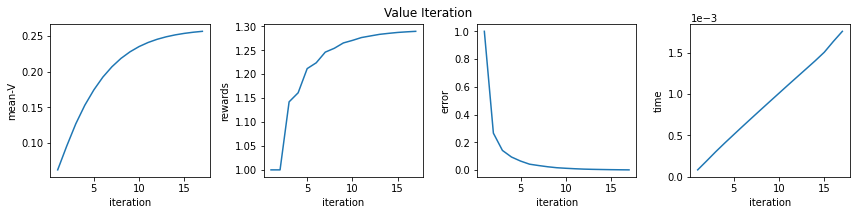

In [184]:
fig = plt.figure(figsize=(12,3))
fig.suptitle('Value Iteration')

ax1 = fig.add_subplot(141)
ax1.plot(iters, mean_V)
ax1.set_xlabel("iteration")
ax1.set_ylabel("mean-V")

ax2 = fig.add_subplot(142)
ax2.plot(iters, rewards)
ax2.set_xlabel("iteration")
ax2.set_ylabel("rewards")

ax3 = fig.add_subplot(143)
ax3.plot(iters, error)
ax3.set_xlabel("iteration")
ax3.set_ylabel("error")

ax4 = fig.add_subplot(144)
ax4.plot(iters, time)
ax4.set_xlabel("iteration")
ax4.set_ylabel("time")
ax4.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()

### Policy Iteration

In [185]:
gamma = np.round(np.arange(0.1, 1.0, 0.1), 2)
print(gamma)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [186]:
pi_policies = []
for g in gamma:
    env.reset()
    P, R = convert_gym_transition_matrix(env)

    pi = mdp.PolicyIteration(P, R, gamma=g)
    pi.run()

    pi_policies.append(pi.policy)

print(np.asarray(pi_policies))

[[3 2 2 2 0 2 2 1 0 2 3 0 1 0 0 0]
 [3 2 2 2 0 2 2 1 0 2 3 0 1 0 0 0]
 [3 2 2 2 0 2 2 1 0 2 3 0 1 0 0 0]
 [3 2 2 2 0 2 2 1 0 2 3 0 1 0 0 0]
 [3 2 2 2 0 2 2 1 0 2 3 0 1 0 0 0]
 [3 2 2 2 0 2 2 1 0 2 3 0 1 0 0 0]
 [3 2 2 2 0 2 2 1 0 2 3 0 1 0 0 0]
 [3 2 2 2 0 2 2 1 0 2 3 0 1 0 0 0]
 [3 2 2 2 0 2 2 2 0 2 3 0 1 0 0 0]]


In [187]:
env.reset()
P, R = convert_gym_transition_matrix(env)

pi = mdp.PolicyIteration(P, R, gamma=0.8)
pi.run()

pi_policy = np.asarray(pi.policy)
pi_policy_str = policy_string(pi_policy, action_str=action_str)
run_stats = pi.run_stats

iters = []
rewards = []
mean_V = []
max_V = []
time = []
error = []
for s in run_stats:
    iters.append(s['Iteration'])
    rewards.append(s['Reward'])
    mean_V.append(s['Mean V'])
    max_V.append(s['Max V'])
    time.append(s['Time'])
    error.append(s['Error'])

print(pi_policy.reshape((nrow, ncol)))
print(pi_policy_str.reshape((nrow, ncol)))

[[3 2 2 2]
 [0 2 2 1]
 [0 2 3 0]
 [1 0 0 0]]
[['^' '>' '>' '>']
 ['<' '>' '>' 'v']
 ['<' '>' '^' '<']
 ['v' '<' '<' '<']]


In [188]:
get_score(env, pi_policy, episodes=100000)

----------------------------------------------
You took an average of 33 steps to get the Goal
And you fell in the hole 5.19 % of the times
----------------------------------------------


(32.94646190842835, 0.05189)

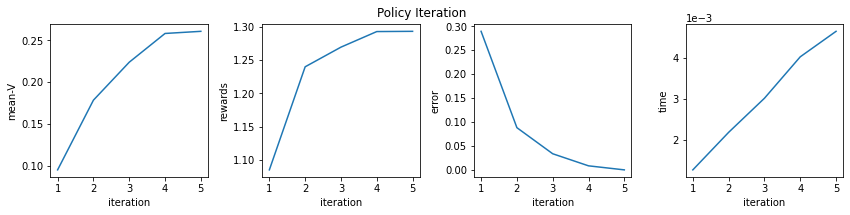

In [189]:
fig = plt.figure(figsize=(12,3))
fig.suptitle('Policy Iteration')

ax1 = fig.add_subplot(141)
ax1.plot(iters, mean_V)
ax1.set_xlabel("iteration")
ax1.set_ylabel("mean-V")

ax2 = fig.add_subplot(142)
ax2.plot(iters, rewards)
ax2.set_xlabel("iteration")
ax2.set_ylabel("rewards")

ax3 = fig.add_subplot(143)
ax3.plot(iters, error)
ax3.set_xlabel("iteration")
ax3.set_ylabel("error")

ax4 = fig.add_subplot(144)
ax4.plot(iters, time)
ax4.set_xlabel("iteration")
ax4.set_ylabel("time")
ax4.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()

### Q-Learning

In [8]:
gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9, 0.9]
alphas = [0.1, 0.5, 0.9]
epsilons = [0.1, 0.3, 0.5]
epsilon_decays = [0.0001, 0.001, 0.1]

env.reset()

0

In [207]:
ql_params = []
ql_policies = []
ql_rewards = []
ql_time = []
ql_errors = []

for g in gammas:
    for a in alphas:
        for e in epsilons:
            for decay in epsilon_decays:
                env.reset()
                P, R = convert_gym_transition_matrix(env)

                ql = mdp.QLearning(P, R, gamma=g, alpha=a, epsilon=e, epsilon_decay=decay, n_iter=100000)
                ql.run()
                
                ql_policies.append(ql.policy)
                ql_params.append([g,a,e,decay])
                
                stats = ql.run_stats
                ql_rewards.append(stats[-1]["Reward"])
                ql_time.append(stats[-1]["Time"])
                ql_errors.append(stats[-1]["Error"])
                
print(np.asarray(ql_policies))

[[2 1 0 ... 2 0 0]
 [2 2 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [3 0 1 ... 0 0 0]
 [1 3 1 ... 0 0 0]
 [3 1 2 ... 0 0 0]]


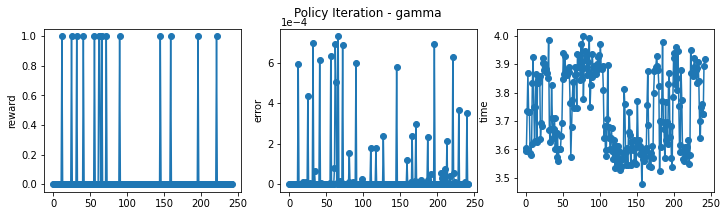

In [210]:
fig = plt.figure(figsize=(12,3))
fig.suptitle('Policy Iteration - gamma')


ax1 = fig.add_subplot(131)
ax1.plot(ql_rewards,'-o')
ax1.set_xlabel("")
ax1.set_ylabel("reward")

ax2 = fig.add_subplot(132)
ax2.plot(ql_errors,'-o')
ax2.set_xlabel("")
ax2.set_ylabel("error")
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax3 = fig.add_subplot(133)
ax3.plot(ql_time, '-o')
ax3.set_xlabel("")
ax3.set_ylabel("time")
ax3.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

In [218]:
df = pd.DataFrame({"rewards": ql_rewards,
                    "errors": ql_errors,
                    "times": ql_time,
                    "params": ql_params
                   })

In [230]:
df_ql = df[df["rewards"]==1]
df_ql

,rewards,errors,times,params
12,1.0,0.000595,3.630236,"[0.1, 0.5, 0.3, 0.0001]"
25,1.0,0.000437,3.879041,"[0.1, 0.9, 0.5, 0.001]"
32,1.0,0.000699,3.668102,"[0.2, 0.1, 0.3, 0.1]"
41,1.0,0.000614,3.656861,"[0.2, 0.5, 0.3, 0.1]"
56,1.0,0.000631,3.863943,"[0.3, 0.1, 0.1, 0.1]"
62,1.0,0.000693,3.678887,"[0.3, 0.1, 0.5, 0.1]"
63,1.0,0.000505,3.774993,"[0.3, 0.5, 0.1, 0.0001]"
66,1.0,0.000731,3.862090,"[0.3, 0.5, 0.3, 0.0001]"
72,1.0,0.000689,3.931260,"[0.3, 0.9, 0.1, 0.0001]"
90,1.0,0.000597,3.937256,"[0.4, 0.5, 0.1, 0.0001]"


In [231]:
g,a,e,decay = [0.9, 0.1, 0.3, 0.1]

env.reset()
P, R = convert_gym_transition_matrix(env)

ql = mdp.QLearning(P, R, gamma=g, alpha=a, epsilon=e, epsilon_decay=decay, n_iter=100000)
ql.run()

ql_policy = np.asarray(ql.policy)
ql_policy_str = policy_string(ql_policy, action_str=action_str)
print(ql_policy.reshape((nrow,ncol)))
print(ql_policy_str.reshape((nrow, ncol)))
get_score(env, ql_policy)

[[1 0 0 0]
 [0 2 3 0]
 [0 2 2 0]
 [2 0 0 0]]
[['v' '<' '<' '<']
 ['<' '>' '^' '<']
 ['<' '>' '>' '<']
 ['>' '<' '<' '<']]
----------------------------------------------
You took an average of 20 steps to get the Goal
And you fell in the hole 94.02 % of the times
----------------------------------------------


(19.926421404682273, 0.9402)

In [232]:
ql.run_stats[-1]["Reward"]

0.0

## Frozen Lake 16x16

In [247]:
env = env_20
nrow = env.env.nrow
ncol = env.env.ncol
env.reset()
env.render()


SFHFHHFFFFFHHHHHFHHF
HFHHFHHFHFFHFHHFHHFF
FFFFFHHHFHFFFHFFFHFH
FHHFHFFFHFFFFFFFHHHH
FFFFHHFFFHFFFFHHFFFH
FFFFFFHFHHFFHFFHHHFH
FHFHFFFFFFHFFFFHFFFF
FHFFFFHHFFFFHFFHHFFF
FHFFFHHHHHFFFHFFFFFF
FHFFFFFHFHFHHFHFFFHF
FFFFFFHFFFHFFFHFFHHF
HHFHFHHHFFHFHHFFHFHH
FFFHFHFFHHHHFFFFFFFH
FFHFHHFFFHHFFFHHFHFF
HFFFFFFFHFFHFFFFFFHF
FFHFFFHFHFHFFFFHFFHH
FFFFHFFHFFFFHHHFHFFF
FFFHFHFFHFHFFFFHFFHF
FHFFFHHHHFHHFFHFHFFH
FFFFHHFFFFHHFFHFHHFG


### Value Iteration 16x16

In [288]:
env = env_20
env.reset()
gamma = np.round(np.arange(0.1, 1.0, 0.1), 2)
print(gamma)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [289]:
vi_policies = []
vi_rewards = []
vi_time = []
vi_errors = []

for g in gamma:
    env.reset()
    P, R = convert_gym_transition_matrix(env)
    
    vi = mdp.ValueIteration(P, R, gamma=g)
    vi.run()
    
    vi_policies.append(vi.policy)
    vi_time.append(vi.time)
    
    stats = vi.run_stats
    vi_rewards.append(stats[-1]["Reward"])
    vi_errors.append(stats[-1]["Error"])
                
print(np.asarray(vi_policies))

[[0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]]


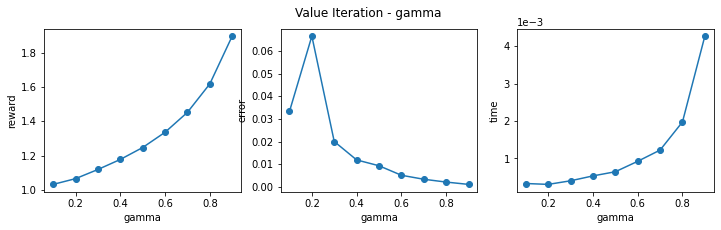

In [290]:
fig = plt.figure(figsize=(12,3))
fig.suptitle('Value Iteration - gamma')

ax1 = fig.add_subplot(131)
ax1.plot(gamma, vi_rewards,'-o')
ax1.set_xlabel("gamma")
ax1.set_ylabel("reward")

ax2 = fig.add_subplot(132)
ax2.plot(gamma, vi_errors,'-o')
ax2.set_xlabel("gamma")
ax2.set_ylabel("error")

ax3 = fig.add_subplot(133)
ax3.plot(gamma, vi_time, '-o')
ax3.set_xlabel("gamma")
ax3.set_ylabel("time")
ax3.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

In [301]:
env.reset()
P, R = convert_gym_transition_matrix(env)

vi = mdp.ValueIteration(P, R, gamma=0.9)
vi.run()

vi_policy = np.asarray(vi.policy)
vi_policy_str = policy_string(vi_policy, action_str=action_str)
run_stats = vi.run_stats

iters = []
rewards = []
mean_V = []
max_V = []
time = []
error = []
for s in run_stats:
    iters.append(s['Iteration'])
    rewards.append(s['Reward'])
    mean_V.append(s['Mean V'])
    max_V.append(s['Max V'])
    time.append(s['Time'])
    error.append(s['Error'])

# print(vi_policy.reshape((nrow, ncol)))
# print(vi_policy_str.reshape((nrow, ncol)))

In [302]:
get_score(env, vi_policy)

----------------------------------------------
You took an average of 90 steps to get the Goal
And you fell in the hole 99.34 % of the times
----------------------------------------------


(89.81818181818181, 0.9934)

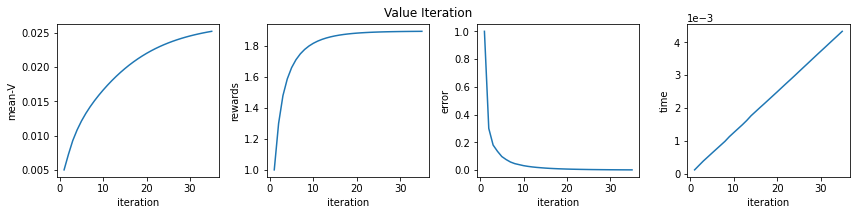

In [303]:
fig = plt.figure(figsize=(12,3))
fig.suptitle('Value Iteration')

ax1 = fig.add_subplot(141)
ax1.plot(iters, mean_V)
ax1.set_xlabel("iteration")
ax1.set_ylabel("mean-V")

ax2 = fig.add_subplot(142)
ax2.plot(iters, rewards)
ax2.set_xlabel("iteration")
ax2.set_ylabel("rewards")

ax3 = fig.add_subplot(143)
ax3.plot(iters, error)
ax3.set_xlabel("iteration")
ax3.set_ylabel("error")

ax4 = fig.add_subplot(144)
ax4.plot(iters, time)
ax4.set_xlabel("iteration")
ax4.set_ylabel("time")
ax4.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()

### Policy Iteration 16x16

In [282]:
env = env_16
gamma = np.round(np.arange(0.1, 1.0, 0.1), 2)
print(gamma)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [283]:
pi_policies = []
pi_rewards = []
pi_time = []
pi_errors = []

for g in gamma:
    env.reset()
    P, R = convert_gym_transition_matrix(env)
    
    pi = mdp.PolicyIteration(P, R, gamma=g)
    pi.run()
    
    pi_policies.append(pi.policy)
    pi_time.append(pi.time)
    
    stats = pi.run_stats
    pi_rewards.append(stats[-1]["Reward"])
    pi_errors.append(stats[-1]["Error"])
                
print(np.asarray(pi_policies))

[[1 2 2 ... 2 1 0]
 [1 2 2 ... 2 1 0]
 [1 2 2 ... 2 1 0]
 ...
 [1 2 2 ... 2 1 0]
 [1 2 2 ... 2 1 0]
 [1 2 2 ... 2 1 0]]


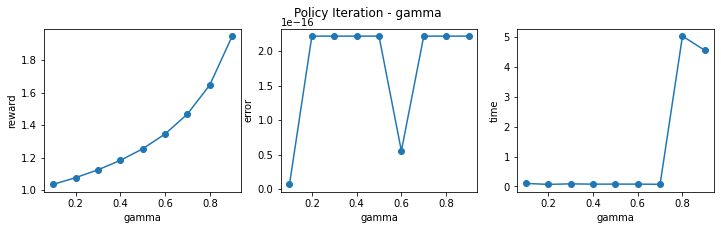

In [284]:
fig = plt.figure(figsize=(12,3))
fig.suptitle('Policy Iteration - gamma')


ax1 = fig.add_subplot(131)
ax1.plot(gamma, pi_rewards,'-o')
ax1.set_xlabel("gamma")
ax1.set_ylabel("reward")

ax2 = fig.add_subplot(132)
ax2.plot(gamma, pi_errors,'-o')
ax2.set_xlabel("gamma")
ax2.set_ylabel("error")


ax3 = fig.add_subplot(133)
ax3.plot(gamma, pi_time, '-o')
ax3.set_xlabel("gamma")
ax3.set_ylabel("time")
ax3.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

In [285]:
env.reset()
P, R = convert_gym_transition_matrix(env)

pi = mdp.PolicyIteration(P, R, gamma=0.6)
pi.run()

pi_policy = np.asarray(pi.policy)
pi_policy_str = policy_string(pi_policy, action_str=action_str)
run_stats = pi.run_stats

iters = []
rewards = []
mean_V = []
max_V = []
time = []
error = []
for s in run_stats:
    iters.append(s['Iteration'])
    rewards.append(s['Reward'])
    mean_V.append(s['Mean V'])
    max_V.append(s['Max V'])
    time.append(s['Time'])
    error.append(s['Error'])

# print(pi_policy.reshape((nrow, ncol)))
# print(pi_policy_str.reshape((nrow, ncol)))

In [286]:
get_score(env, pi_policy)

----------------------------------------------
You took an average of 83 steps to get the Goal
And you fell in the hole 86.57 % of the times
----------------------------------------------


(83.26656738644824, 0.8657)

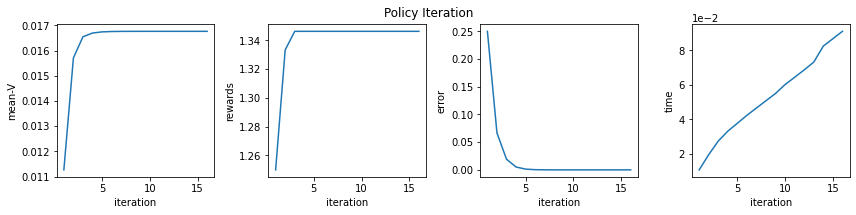

In [287]:
fig = plt.figure(figsize=(12,3))
fig.suptitle('Policy Iteration')

ax1 = fig.add_subplot(141)
ax1.plot(iters, mean_V)
ax1.set_xlabel("iteration")
ax1.set_ylabel("mean-V")

ax2 = fig.add_subplot(142)
ax2.plot(iters, rewards)
ax2.set_xlabel("iteration")
ax2.set_ylabel("rewards")

ax3 = fig.add_subplot(143)
ax3.plot(iters, error)
ax3.set_xlabel("iteration")
ax3.set_ylabel("error")

ax4 = fig.add_subplot(144)
ax4.plot(iters, time)
ax4.set_xlabel("iteration")
ax4.set_ylabel("time")
ax4.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()

### Q-Learning

In [304]:
gammas = [0.1, 0.3, 0.5, 0.7, 0.9]
alphas = [0.1, 0.5, 0.9]
epsilons = [0.1, 0.5]
epsilon_decays = [0.0001, 0.001]

env = env_16
env.reset()

0

In [305]:
ql_params = []
ql_policies = []
ql_rewards = []
ql_time = []
ql_errors = []

for g in gammas:
    for a in alphas:
        for e in epsilons:
            for decay in epsilon_decays:
                env.reset()
                P, R = convert_gym_transition_matrix(env)

                ql = mdp.QLearning(P, R, gamma=g, alpha=a, epsilon=e, epsilon_decay=decay, n_iter=100000)
                ql.run()
                
                ql_policies.append(ql.policy)
                ql_time.append(ql.time)                
                ql_params.append([g,a,e,decay])
                
                stats = ql.run_stats
                ql_rewards.append(stats[-1]["Reward"])
                ql_errors.append(stats[-1]["Error"])
                
print(np.asarray(ql_policies))

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


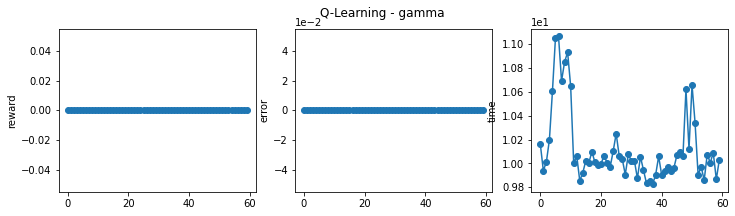

In [307]:
fig = plt.figure(figsize=(12,3))
fig.suptitle('Q-Learning - gamma')


ax1 = fig.add_subplot(131)
ax1.plot(ql_rewards,'-o')
ax1.set_xlabel("")
ax1.set_ylabel("reward")

ax2 = fig.add_subplot(132)
ax2.plot(ql_errors,'-o')
ax2.set_xlabel("")
ax2.set_ylabel("error")
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax3 = fig.add_subplot(133)
ax3.plot(ql_time, '-o')
ax3.set_xlabel("")
ax3.set_ylabel("time")
ax3.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

In [308]:
g,a,e,decay = [0.9, 0.1, 0.3, 0.1]

env.reset()
P, R = convert_gym_transition_matrix(env)

ql = mdp.QLearning(P, R, gamma=g, alpha=a, epsilon=e, epsilon_decay=decay, n_iter=100000)
ql.run()

ql_policy = np.asarray(ql.policy)
ql_policy_str = policy_string(ql_policy, action_str=action_str)



iters = []
rewards = []
mean_V = []
max_V = []
time = []
error = []
for s in run_stats:
    iters.append(s['Iteration'])
    rewards.append(s['Reward'])
    mean_V.append(s['Mean V'])
    max_V.append(s['Max V'])
    time.append(s['Time'])
    error.append(s['Error'])

# print(ql_policy.reshape((nrow,ncol)))
# print(ql_policy_str.reshape((nrow, ncol)))
get_score(env, ql_policy)

----------------------------------------------
You took an average of nan steps to get the Goal
And you fell in the hole 100.00 % of the times
----------------------------------------------


(nan, 1.0)

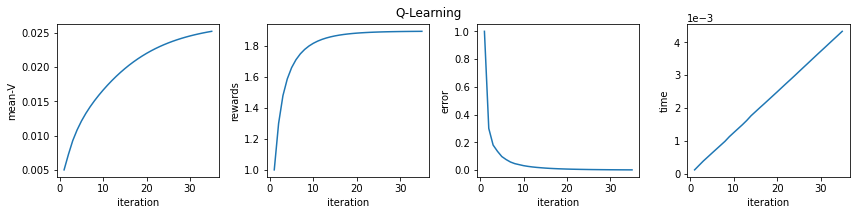

In [309]:
fig = plt.figure(figsize=(12,3))
fig.suptitle('Q-Learning')

ax1 = fig.add_subplot(141)
ax1.plot(iters, mean_V)
ax1.set_xlabel("iteration")
ax1.set_ylabel("mean-V")

ax2 = fig.add_subplot(142)
ax2.plot(iters, rewards)
ax2.set_xlabel("iteration")
ax2.set_ylabel("rewards")

ax3 = fig.add_subplot(143)
ax3.plot(iters, error)
ax3.set_xlabel("iteration")
ax3.set_ylabel("error")

ax4 = fig.add_subplot(144)
ax4.plot(iters, time)
ax4.set_xlabel("iteration")
ax4.set_ylabel("time")
ax4.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()